In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

Using TensorFlow backend.


## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [12]:
%run utils.py

In [3]:
%run models.py

In [13]:
%%time

image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  data/ML101_KS.csv . ( 1  of  16 )
117  frames generated with label  1 .117


Processing session:  data/ML101_US.csv . ( 2  of  16 )
112  frames generated with label  0 .112


Processing session:  data/ML102_KS.csv . ( 3  of  16 )
111  frames generated with label  1 .111


Processing session:  data/ML102_US.csv . ( 4  of  16 )
109  frames generated with label  0 ./109


Processing session:  data/ML103_KS.csv . ( 5  of  16 )
113  frames generated with label  1 .113


Processing session:  data/ML103_US.csv . ( 6  of  16 )
104  frames generated with label  0 .104


Processing session:  data/ML104_KS.csv . ( 7  of  16 )
101  frames generated with label  1 .1/101


Processing session:  data/ML104_US.csv . ( 8  of  16 )
102  frames generated with label  0 ./102


Processing session:  data/ML105_KS.csv . ( 9  of  16 )
107  frames generated with label  1 .107


Processing session:  data/ML105_US.csv . ( 10  of  16 )
113  frames generated with lab

In [15]:
X.shape, y.shape

((1821, 28, 28, 3), (1821,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


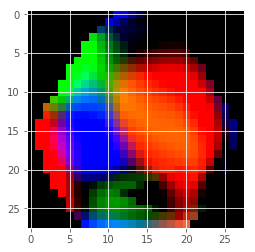

In [19]:
plt.imshow(X[3])

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [21]:
y_train.shape

(1456,)

In [22]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (1456, 28, 28, 3)
1456 train samples
365 test samples


In [23]:
np.mean(x_train)

0.0024639356

In [24]:
batch_size = 32
num_classes = 2
epochs = 200

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = get_model_1(input_shape, num_classes)
# model = get_model_2(input_shape, num_classes)


# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 4s 3ms/step - loss: 0.6955 - accuracy: 0.5069 - val_loss: 0.6879 - val_accuracy: 0.5616
Epoch 2/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.6892 - accuracy: 0.5378 - val_loss: 0.6834 - val_accuracy: 0.5863
Epoch 3/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6817 - accuracy: 0.5865 - val_loss: 0.6742 - val_accuracy: 0.5973
Epoch 4/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.6734 - accuracy: 0.6030 - val_loss: 0.6715 - val_accuracy: 0.5918
Epoch 5/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.6668 - accuracy: 0.6250 - val_loss: 0.6635 - val_accuracy: 0.6247
Epoch 6/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.6600 - accuracy: 0.6284 - val_loss: 0.6586 - val_accuracy: 0.6137
Epoch 7/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.6503

Epoch 57/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.4015 - accuracy: 0.8455 - val_loss: 0.5416 - val_accuracy: 0.7233
Epoch 58/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.3999 - accuracy: 0.8352 - val_loss: 0.5257 - val_accuracy: 0.7342
Epoch 59/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.3923 - accuracy: 0.8462 - val_loss: 0.5383 - val_accuracy: 0.7342
Epoch 60/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.3910 - accuracy: 0.8496 - val_loss: 0.5870 - val_accuracy: 0.6959
Epoch 61/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.3902 - accuracy: 0.8386 - val_loss: 0.5375 - val_accuracy: 0.7425
Epoch 62/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.3795 - accuracy: 0.8475 - val_loss: 0.5406 - val_accuracy: 0.7178
Epoch 63/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.3794 - accuracy: 0.8599 - val_loss: 0.5580 -

1456/1456 [==============================] - 2s 1ms/step - loss: 0.2450 - accuracy: 0.9121 - val_loss: 0.5410 - val_accuracy: 0.7534
Epoch 114/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2492 - accuracy: 0.9093 - val_loss: 0.5439 - val_accuracy: 0.7726
Epoch 115/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2371 - accuracy: 0.9183 - val_loss: 0.6811 - val_accuracy: 0.7178
Epoch 116/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2374 - accuracy: 0.9203 - val_loss: 0.5465 - val_accuracy: 0.7781
Epoch 117/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2399 - accuracy: 0.9107 - val_loss: 0.6750 - val_accuracy: 0.7288
Epoch 118/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2339 - accuracy: 0.9100 - val_loss: 0.5455 - val_accuracy: 0.7616
Epoch 119/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2318 - accuracy: 0.9190 - val_loss: 0.5514 - val_ac

Epoch 169/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1445 - accuracy: 0.9650 - val_loss: 0.5988 - val_accuracy: 0.7644
Epoch 170/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1352 - accuracy: 0.9670 - val_loss: 0.7419 - val_accuracy: 0.7507
Epoch 171/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1387 - accuracy: 0.9581 - val_loss: 0.6397 - val_accuracy: 0.7699
Epoch 172/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1433 - accuracy: 0.9554 - val_loss: 0.6464 - val_accuracy: 0.7479
Epoch 173/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1406 - accuracy: 0.9533 - val_loss: 0.6360 - val_accuracy: 0.7781
Epoch 174/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1375 - accuracy: 0.9643 - val_loss: 0.6276 - val_accuracy: 0.7644
Epoch 175/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1326 - accuracy: 0.9636 - val_loss: 0